In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function
from __future__ import unicode_literals

import sys, os, copy
sys.path.insert(0,r"C:\Users\nanw0\GoogleDrive\SLAC\SLAC-Diling\8. 20 Winter\Beam_propagation\WPG\WPG-develop")
sys.path.insert(0,os.path.join('..','..'))

import time
import numpy as np
import pylab as plt

# import auxiliar functions
from Auxiliary import *


In [24]:
''' crystal variables  '''
crystal_type='220'
ang_as = np.deg2rad(5)           # asymmetric angle
if_flip = 0
ang_as3 = -np.deg2rad(5)

if crystal_type == '111':
    ''' Silicon 111 crystal '''
    d_sp = 3.13557135638            # reflecting plane d-spacing [A]
    psi0r = -5.11321939903e-05      # real part of 0th Fourier component of crystal polarizability
    psi0i = 3.58887560736e-06       # imaginary part of ""
    psi_hr = -2.71341902391e-05     # real part of Hth Fourier component
    psi_hi = 2.50565837652e-06      # imaginary part of ""
    psi_hbr = -2.71341902391e-05    # real part of -Hth Fourier coumponent
    psi_hbi = 2.50565837652e-06     # imaginary part of ""
    
if crystal_type == '220':
    ''' Silicon 220 crystal '''
    d_sp = 1.9201374688016222        # reflecting plane d-spacing [A]
    psi0r = -9.7640050694412e-06     # real part of 0th Fourier component of crystal polarizability
    psi0i = 1.4938680132506875e-07   # imaginary part of ""
    psi_hr = -5.932463856370471e-06  # real part of Hth Fourier component
    psi_hi = 1.44406950529943e-07    # imaginary part of ""
    psi_hbr = -5.932463856370471e-06 # real part of -Hth Fourier coumponent
    psi_hbi = 1.44406950529943e-07   # imaginary part of ""
    
tc = 0.01                       # crystal thickness
uc = 1                          # use case: 1 (Bragg reflection); 2 (Bragg transmission)
ang_dif_pl = 0                   # diffraction plane angle: 0 (vertical); pi/2 (horizontal)
Temp_Crystal = SRWLOptCryst(d_sp,psi0r,psi0i,psi_hr,psi_hi,psi_hbr,psi_hbi,tc,ang_as,_uc=uc)

''' incident beam variables '''
ekev = 10.0                 # photon energy [kev]
pulse_duration = 1e-15    # pulse duration (rms) [t]
z1 = 200.0                  # distance to first OE [m]
sigX = 50e-6/2.36           # w0 (rms) [m]
npoints = 2000              # wavefront sampling dimension
if_load_input = 0           # load (1) or generate (0) incident wavefront

# default values
qnC = 0.1                   # charge [nC]
pulseEnergy = 0.5e-3        # pulse energy [J]
dt = 0.5e-15                # time sampling resolution
if pulse_duration/dt <= 10:
    print('incident beam too short, changing to finer sampling resolution ...')
    dt = 0.1e-15
    if pulse_duration/dt <= 10:
        print(".... okay, the beam is really too short, simulation might break down")
hbar = 6.582119569e-16

# input dimensions
npointsx = 2                # number of points vs horizontal position
npointsy = npoints          # """"""""""""""""""  vertical position

incident beam too short, changing to finer sampling resolution ...


In [25]:
''' calculations '''
wl0 = E2L(ekev*1e3)                 # wavelength
k0 = 2*np.pi/wl0                    # wavenumber
divergence = wl0/np.pi/sigX         # paraxial beam divergence (rms)
range_xy = divergence/2 * z1 * 10   # spatial sampling range (5 sigma)
#range_xy = divergence/2 * z1 * 2 * np.floor(2e-3/(divergence/2 * z1 * 2))
nvx0, nvy0, nvz0 = Temp_Crystal.find_orient(ekev*1e3,ang_dif_pl)[0][2]
thetaB0 = np.arctan(-nvz0/nvy0)+ang_as

trange = calc_stretching(thetaB0, ang_as, range_xy)    # stretched pulse duration
pulseRange = trange/pulse_duration

if pulseRange < 400:
    pulseRange = 400
    trange = pulse_duration * pulseRange

if trange > 1000e-15:
    trange = 1000e-15
    pulseRange = trange/pulse_duration

if trange < 300e-15:
    trange = 300e-15
    pulseRange = trange/pulse_duration
    
dev = 1/trange * 2*np.pi * hbar     # photon energy sampling resolution
nz = int(trange/dt)                 # number of photon energy slices
if nz % 2!=0:
    nz += 1

print('beam parameters:\n    {}keV, {}fs, {}um w0, {}urad divergence'.format(
    ekev, round(pulse_duration*1e15,2), round(sigX*1e6,2), round(divergence*1e6,2)))
print('sampling parameters:\n    {}mm range, {}meV deV, {} nz, {} pulseRange'.format(
    round(range_xy*1e3,2), round(dev*1e3,2), nz, round(pulseRange,2)))
print('other parameters:\n    Bragg angle {}deg, stretched pulse length {}fs'.format(
    round(np.rad2deg(thetaB0),2),round(trange*1e15,2)))
print('Fresnel distance {}um'.format(
    round((3e8*0.1e-15)**2/wl0*1e6,2)))


beam parameters:
    10.0keV, 1.0fs, 21.19um w0, 1.86urad divergence
sampling parameters:
    1.86mm range, 4.14meV deV, 10000 nz, 1000.0 pulseRange
other parameters:
    Bragg angle 18.84deg, stretched pulse length 1000.0fs
Fresnel distance 7.25um


In [26]:
''' directories '''
# output data directory
strDataFolderName = 'WPG_output/Tail_Debug/'

# sub-folder for current sampling parameters
dirname_duration = strDataFolderName+'Si_{}_{}fs_beam/'.format(
    crystal_type,round(pulse_duration*1e15,1))

# sub-sub-folder for incident beam
dirname_input = dirname_duration+'incident_beam/'

# sub-sub-folder for propagated beam
dirname_prop = dirname_duration+'propagation/'
if if_flip == 1:
    dirname_prop = dirname_duration+'propagation_flip/'

''' filenames '''
name0 = 'incident'
name1 = 'C1'
name2 = 'C2'
name3 = 'C3'
name4 = 'C4'

fname_incident = dirname_input+'incident_compressed.h5'
fname_c1 = dirname_prop+'wf_{}deg_{}_compressed.h5'.format(round(np.rad2deg(ang_as),2),name1)
fname_c2  = dirname_prop+'wf_{}deg_{}_compressed.h5'.format(round(np.rad2deg(ang_as),2),name2)
fname_c3 = dirname_prop+'wf_{}deg_{}_compressed.h5'.format(round(np.rad2deg(ang_as),2),name3)
fname_c4  = dirname_prop+'wf_{}deg_{}_compressed.h5'.format(round(np.rad2deg(ang_as),2),name4)
if if_flip == 1:
    fname_c4 = fname_c4  = dirname_prop+'wf_{}_{}deg_{}_compressed.h5'.format(round(np.rad2deg(ang_as),2),round(np.rad2deg(ang_as3),2),name4)


### Plot

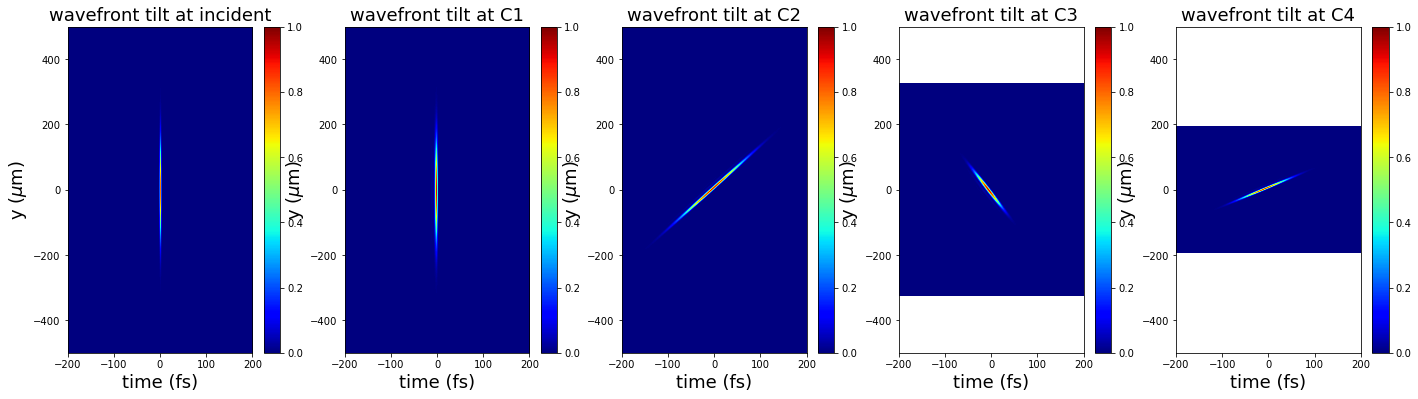

In [27]:
''' wavefront profile everywhere '''
if_log = 0
fov_y = 1000    # um
fov_t = trange*1e15    # fs
fov_t = 400

#cmax = np.max(mwf.get_intensity())
plt.figure(figsize=(24,6))
plt.subplot(1,5,1)
plot_tilt_from_file(fname_incident, label=name0,if_log=if_log)
plt.xlim([-fov_t/2,fov_t/2]); plt.ylim([-fov_y/2,fov_y/2])

plt.subplot(1,5,2)
plot_tilt_from_file(fname_c1, label=name1,if_log=if_log)
plt.xlim([-fov_t/2,fov_t/2]); plt.ylim([-fov_y/2,fov_y/2])

plt.subplot(1,5,3)
plot_tilt_from_file(fname_c2, label=name2,if_log=if_log)
plt.xlim([-fov_t/2,fov_t/2]); plt.ylim([-fov_y/2,fov_y/2])

plt.subplot(1,5,4)
plot_tilt_from_file(fname_c3, label=name3,if_log=if_log)
plt.xlim([-fov_t/2,fov_t/2]); plt.ylim([-fov_y/2,fov_y/2])

plt.subplot(1,5,5)
plot_tilt_from_file(fname_c4, label=name4,if_log=if_log)
plt.xlim([-fov_t/2,fov_t/2]); plt.ylim([-fov_y/2,fov_y/2])

plt.savefig(dirname_prop+'wavefront_tilt_{}deg_miscut.png'.format(
    round(np.rad2deg(ang_as),2)),transparent=True)


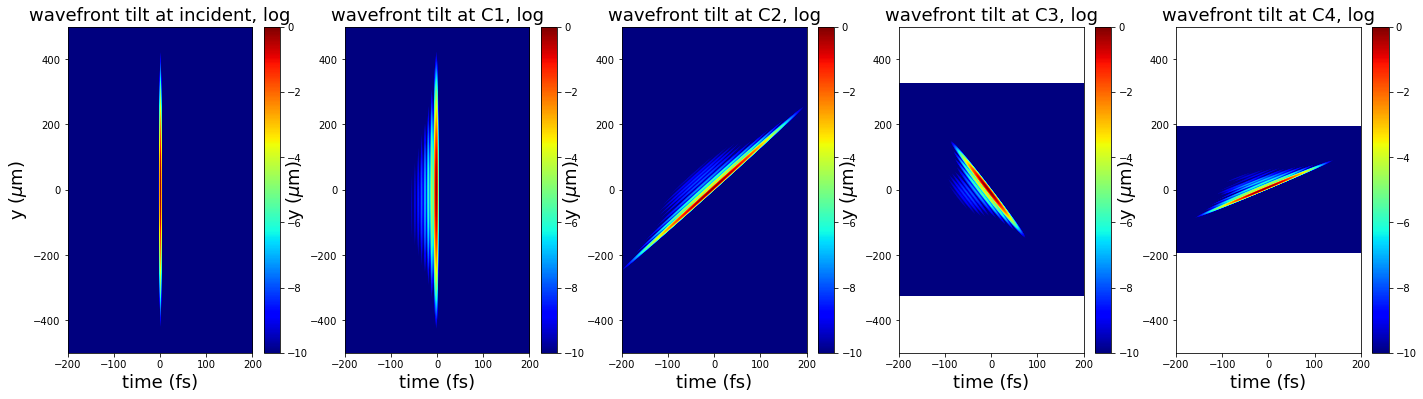

In [28]:
''' wavefront profile everywhere log '''
if_log = 1

plt.figure(figsize=(24,6))
plt.subplot(1,5,1)
plot_tilt_from_file(fname_incident, label=name0,if_log=if_log)
plt.xlim([-fov_t/2,fov_t/2]); plt.ylim([-fov_y/2,fov_y/2])

plt.subplot(1,5,2)
plot_tilt_from_file(fname_c1, label=name1,if_log=if_log)
plt.xlim([-fov_t/2,fov_t/2]); plt.ylim([-fov_y/2,fov_y/2])

plt.subplot(1,5,3)
plot_tilt_from_file(fname_c2, label=name2,if_log=if_log)
plt.xlim([-fov_t/2,fov_t/2]); plt.ylim([-fov_y/2,fov_y/2])

plt.subplot(1,5,4)
plot_tilt_from_file(fname_c3, label=name3,if_log=if_log)
plt.xlim([-fov_t/2,fov_t/2]); plt.ylim([-fov_y/2,fov_y/2])

plt.subplot(1,5,5)
plot_tilt_from_file(fname_c4, label=name4,if_log=if_log)
plt.xlim([-fov_t/2,fov_t/2]); plt.ylim([-fov_y/2,fov_y/2])

plt.savefig(dirname_prop+'wavefront_tilt_{}deg_miscut_log.png'.format(
    round(np.rad2deg(ang_as),2)),transparent=True)


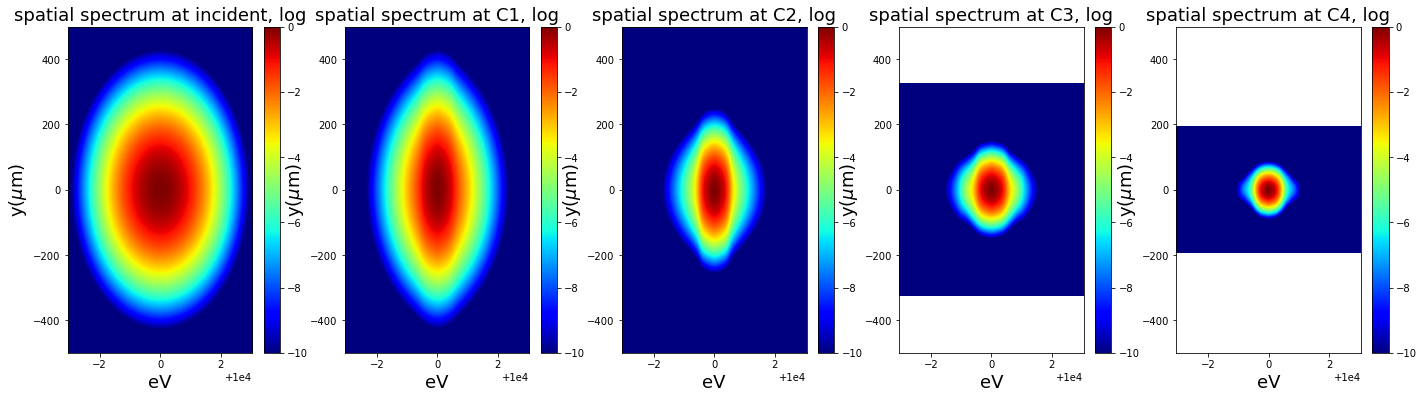

In [29]:
''' spatial spectrum everywhere '''
aw, axis_ev, int_ev = get_spectra_from_file(fname_incident)

eRange = axis_ev.max()-axis_ev.min()
eMin = axis_ev[aw.min()]-eRange/20
eMax = axis_ev.max()-(eMin-axis_ev.min())

plt.figure(figsize=(24,6))
plt.subplot(1,5,1)
plot_tilt_freq_from_file(fname_incident,label=name0,if_log=if_log)
plt.xlim([eMin, eMax]); plt.ylim([-fov_y/2,fov_y/2])

plt.subplot(1,5,2)
plot_tilt_freq_from_file(fname_c1,label=name1,if_log=if_log)
plt.xlim([eMin, eMax]); plt.ylim([-fov_y/2,fov_y/2])

plt.subplot(1,5,3)
plot_tilt_freq_from_file(fname_c2,label=name2,if_log=if_log)
plt.xlim([eMin, eMax]); plt.ylim([-fov_y/2,fov_y/2])

plt.subplot(1,5,4)
plot_tilt_freq_from_file(fname_c3,label=name3,if_log=if_log)
plt.xlim([eMin, eMax]); plt.ylim([-fov_y/2,fov_y/2])

plt.subplot(1,5,5)
plot_tilt_freq_from_file(fname_c4,label=name4,if_log=if_log)
plt.xlim([eMin, eMax]); plt.ylim([-fov_y/2,fov_y/2])

plt.savefig(dirname_prop+'spatial_spectrum_{}deg_miscut_log.png'.format(
    round(np.rad2deg(ang_as),2)),transparent=True)

In [30]:
dirname_prop

'WPG_output/Tail_Debug/Si_220_1.0fs_beam/propagation/'